In [ ]:
# Train multiclass model for classification

import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import classification_report
import torch
import numpy as np

# 1. Load the dataset
df = pd.read_csv("reddit_sentiment_labeled_5000.csv")
label_map = {"Positive": 0, "Negative": 1, "Suggestion": 2, "Neutral": 3}
df["label"] = df["label"].map(label_map)

# 2. Convert to HuggingFace Dataset
dataset = Dataset.from_pandas(df[["text", "label"]])
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# 3. Tokenize
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_fn(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

tokenized_ds = dataset.map(tokenize_fn, batched=True)

# 4. Load Model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# 5. TrainingArguments
training_args = TrainingArguments(
    output_dir="./bert-multiclass-results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# 6. Evaluation Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    report = classification_report(labels, preds, target_names=list(label_map.keys()), output_dict=True)
    return {
        "accuracy": report["accuracy"],
        "f1_positive": report["Positive"]["f1-score"],
        "f1_negative": report["Negative"]["f1-score"],
        "f1_suggestion": report["Suggestion"]["f1-score"],
        "f1_neutral": report["Neutral"]["f1-score"]
    }

# 7. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 8. Train
trainer.train()

# 9. Save model
trainer.save_model("./bert-multiclass-model")
tokenizer.save_pretrained("./bert-multiclass-model")


Map:   0%|          | 0/4020 [00:00<?, ? examples/s]

Map:   0%|          | 0/1006 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/w4/fvh2x8gx6639vy7vkjnqzs1w0000gn/T/ipykernel_1633/844038094.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


In [1]:
import praw
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import gensim
from gensim import corpora
from gensim.models import LdaMulticore
from transformers import pipeline
import numpy as np
from minisom import MiniSom  # pip install minisom
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os
import pandas as pd

In [10]:
def initialize_nlp():
    nlp = spacy.load("en_core_web_sm")
    nltk.download("stopwords")
    nltk.download("punkt")
    return nlp

def clean_lda_keywords_with_pos(topic_terms):
    raw_keywords = [kw.split("*")[1].replace('"', '').strip() for kw in topic_terms.split("+")]
    doc = nlp(" ".join(raw_keywords))
    allowed_pos = {"NOUN", "PROPN", "ADJ"}  # nouns, adjectives
    filtered = [token.text for token in doc if token.pos_ in allowed_pos]
    return filtered[:5]

def get_reddit_posts(cache_path="reddit_buyitforlife_posts.csv"):
    if os.path.exists(cache_path):
        print(" Loading posts from cached CSV...")
        df = pd.read_csv(cache_path)
        posts = list(zip(df["title"], df["body"]))
    else:
        print(" Fetching posts from Reddit API...")
        reddit = praw.Reddit(
            client_id="9ETAXWFx9IHiC7AOh8-APg",
            client_secret="TuskU4_ysvTwaJJ3i9K40HLEiykE9A",
            user_agent="python:brand-sentiment-analyzer:v1.0 (by /u/Soul_Pay4951)"
        )
        subreddit = reddit.subreddit("buyitforlife")
        posts = []
        for post in subreddit.hot(limit=300):
            post.comments.replace_more(limit=0)
            comments = [comment.body for comment in post.comments.list()]
            top_comments = " ".join(comments[:3])  # optional
            title = post.title.strip()
            body = (post.selftext + " " + top_comments).strip()
            posts.append((title, body))

        # Save to CSV
        df = pd.DataFrame(posts, columns=["title", "body"])
        df.to_csv(cache_path, index=False)
        print(f" Saved {len(posts)} posts to {cache_path}")

    return posts


def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"\W", " ", text)  # Remove special characters
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words("english")]
    return " ".join(tokens)

def preprocess_for_lda(text, stop_words):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return tokens

def extract_entities(text, nlp):
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        if ent.label_ in ["ORG", "PRODUCT"]:
            name = ent.text.strip()

            # Filter out long or messy names
            if len(name.split()) > 3:
                continue
            if any(word.lower() in stopwords.words("english") for word in name.split()):
                continue
            if name.isdigit():
                continue

            # Normalize casing
            name = name.title()

            entities.append((name, ent.label_))
    return entities


def perform_topic_modeling(tokenized_posts, num_topics=3):
    dictionary = corpora.Dictionary(tokenized_posts)
    corpus = [dictionary.doc2bow(post) for post in tokenized_posts]
    lda_model = LdaMulticore(
        corpus,
        num_topics=num_topics,
        id2word=dictionary,
        passes=10,
        workers=2
    )
    topics = lda_model.print_topics(num_words=5)
    return topics, lda_model, corpus, dictionary


import torch
import torch.nn.functional as F

# load pretrained model
tokenizer = AutoTokenizer.from_pretrained("./bert-multiclass-model")
model = AutoModelForSequenceClassification.from_pretrained("./bert-multiclass-model")

# Make sure this matches your model's class mapping
label_map = {
    0: "POSITIVE",
    1: "NEGATIVE",
    2: "SUGGESTION"
}

def analyze_multiclass_sentiments(texts):
    results = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            probs = F.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
        label = label_map[predicted_class]
        score = probs[0][predicted_class].item()
        results.append({"label": label, "score": round(score, 4)})
    return results



In [3]:
from collections import defaultdict
from difflib import get_close_matches

valid_brands = {"ikea"}


def resolve_to_known_brand(entity_text):
    entity_clean = re.sub(r'[^a-z0-9\s]', '', entity_text.lower().strip())
    tokens = entity_clean.split()
    for word in tokens:
        if word in valid_brands:
            return word
    match = get_close_matches(entity_clean, valid_brands, n=1, cutoff=0.85)
    return match[0] if match else None

def get_suggestions_by_org(cleaned_posts, sentiments, entity_lists):
    suggestions_by_org = defaultdict(list)
    for (title, body), sentiment, entities in zip(cleaned_posts, sentiments, entity_lists):
        if sentiment['label'] == 'SUGGESTION' and sentiment['score'] > 0.85:
            text = title + " " + body
            for entity, ent_type in entities:
                if ent_type == "ORG":
                    resolved = resolve_to_known_brand(entity)
                    if resolved:
                        suggestions_by_org[resolved].append(text)
    return suggestions_by_org

def compute_sentiment_breakdown_per_org(cleaned_posts, sentiments, entity_lists):
    org_sentiment_count = defaultdict(lambda: {"POSITIVE": 0, "NEGATIVE": 0, "SUGGESTION": 0})
    for (title, body), sentiment, entities in zip(cleaned_posts, sentiments, entity_lists):
        for entity, ent_type in entities:
            if ent_type == "ORG":
                org_sentiment_count[entity][sentiment['label']] += 1
    return org_sentiment_count


In [4]:
# Simplified Hebbian Learning simulation: updating an association score for each topic.
class HebbianLearning:
    def __init__(self, topics):
        self.topics = topics
        self.associations = {topic: 0.0 for topic in topics}

    def update(self, topic, sentiment_score):
        learning_rate = 0.1
        if topic in self.associations:
            self.associations[topic] += learning_rate * sentiment_score

    def get_associations(self):
        return self.associations

# Self-Organizing Maps (SOM) for clustering sentiment trends.
def cluster_sentiments(senti_vectors):
    if not senti_vectors:
        return None
    data = np.array(senti_vectors)
    # Initialize a SOM with a 3x3 grid.
    som = MiniSom(3, 3, data.shape[1], sigma=0.5, learning_rate=0.5, random_seed=42)
    som.random_weights_init(data)
    som.train_random(data, 100)
    # For each sentiment vector, determine its winning node (cluster).
    clusters = [som.winner(vec) for vec in data]
    return clusters

In [5]:
#visualize SOM
from sklearn.metrics import silhouette_score
import numpy as np

def visualize_som_silhouette(senti_vectors, clusters):
    if not senti_vectors or not clusters:
        print("SOM: Insufficient data for silhouette score.")
        return None

    data = np.array(senti_vectors)
    labels = [f"{c[0]}-{c[1]}" for c in clusters]
    try:
        sil_score = silhouette_score(data, labels)
    except:
        sil_score = 0

    print(f"SOM Silhouette Score: {sil_score:.4f}")
    plt.figure(figsize=(6, 4))
    plt.bar(['SOM Clustering'], [sil_score], color='darkorange')
    plt.ylabel("Silhouette Score")
    plt.title("SOM Cluster Quality")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    return sil_score


In [6]:
#transformers performance
from sklearn.metrics import classification_report

def visualize_transformer_performance(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    accuracy = report['accuracy']
    f1_macro = report['macro avg']['f1-score']

    print(f"Transformer Accuracy: {accuracy:.4f}")
    print(f"Transformer F1 Score: {f1_macro:.4f}")

    labels = ['Accuracy', 'F1 Score']
    values = [accuracy, f1_macro]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, values, color='mediumseagreen')
    plt.ylim(0, 1)
    plt.title("Transformer Performance")
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
    plt.tight_layout()
    plt.show()
    return accuracy, f1_macro


In [7]:
def visualize_method_comparison(lda_score, som_score, transformer_score):
    methods = ['LDA', 'SOM', 'Transformer']
    scores = [lda_score, som_score, transformer_score]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(methods, scores, color=['cornflowerblue', 'darkorange', 'mediumseagreen'])
    plt.ylabel('Evaluation Metric (Scaled 0-1)')
    plt.title('Method Comparison: Insight Value / Quality Metric')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center')
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()


In [19]:
# 1. Load & Clean Data
nlp = initialize_nlp()
posts = get_reddit_posts()
cleaned_posts = [(clean_text(title), clean_text(body)) for title, body in posts]
original_texts = [title + " " + body for title, body in posts]  # Uncleaned
tokenized_posts = [preprocess_for_lda(title + " " + body, stop_words) for title, body in cleaned_posts]

combined_texts = [title + " " + body for title, body in cleaned_posts]

# 2. Sentiment Analysis
sentiments = analyze_multiclass_sentiments(original_texts)
print("\nMulticlass Sentiments:")
for sentiment in sentiments:
    print(sentiment)

# 3. Entity Extraction (Brands/Products)
brands_products = [extract_entities(text, nlp) for text in combined_texts]
print("\nExtracted Entities (Brands/Products):")
for bp in brands_products:
    print(bp)

# 4. LDA Topic Modeling
stop_words = set(stopwords.words("english"))
tokenized_posts = [preprocess_for_lda(text, stop_words) for text in combined_texts]
topics, lda_model, corpus, dictionary = perform_topic_modeling(tokenized_posts, num_topics=12)
print("\nTopics from LDA:")
for topic in topics:
    print(topic)

# 5. Assign Topics and Compute Sentiment Counts per Topic
from collections import defaultdict

def compute_topic_sentiment_counts(lda_model, corpus, sentiments):
    topic_sentiment_counts = defaultdict(lambda: {"POSITIVE": 0, "NEGATIVE": 0, "SUGGESTION": 0})
    for i, bow in enumerate(corpus):
        topic_distribution = lda_model.get_document_topics(bow)
        if topic_distribution:
            dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]
            sentiment_label = sentiments[i]["label"]
            topic_sentiment_counts[dominant_topic][sentiment_label] += 1
    return topic_sentiment_counts

def assign_posts_to_lda_topics(lda_model, corpus, original_texts):
    topic_to_posts = defaultdict(list)
    for i, bow in enumerate(corpus):
        topic_distribution = lda_model.get_document_topics(bow)
        if topic_distribution:
            dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]
            topic_to_posts[dominant_topic].append(original_texts[i])
    return topic_to_posts

topic_sentiment_counts = compute_topic_sentiment_counts(lda_model, corpus, sentiments)
topic_to_posts = assign_posts_to_lda_topics(lda_model, corpus, original_texts)


def clean_example_post(post):
    post = re.sub(r'\s+', ' ', post.strip())  # Clean up whitespace
    post = re.sub(r"[^a-zA-Z0-9,.!?'\"]+", ' ', post)  # Remove garbage characters
    sentences = re.split(r'(?<=[.!?])\s+', post)  # Split into sentences

    # Priority: suggestions, recommendations, or longer useful text
    for s in sentences:
        s = s.strip()
        if 50 < len(s) < 200 and any(word in s.lower() for word in ['suggest', 'recommend', 'quality', 'bought', 'used']):
            return s

    # Fallback to first readable sentence
    for s in sentences:
        if 40 < len(s) < 200:
            return s

    return post[:140] + "..."

# 6. Generate Dashboard-Ready Summary
def generate_user_friendly_summary(topic_id, keywords, sentiment_counts, example_posts=None):
    pos = sentiment_counts.get("POSITIVE", 0)
    neg = sentiment_counts.get("NEGATIVE", 0)
    sug = sentiment_counts.get("SUGGESTION", 0)
    total = pos + neg + sug
    if total == 0:
        return None

    if neg > pos and neg > sug:
        insight = "⚠️ Users are expressing dissatisfaction with this topic."
    elif sug > pos and sug > neg:
        insight = "💡 Users are sharing a lot of suggestions here."
    elif pos > neg and pos > sug:
        insight = "✅ This topic is receiving mostly positive feedback."
    else:
        insight = "📝 Mixed feedback observed."

    return {
        "topic_id": topic_id,
        "keywords": keywords,
        "insight": insight,
        "positive": pos,
        "negative": neg,
        "suggestion": sug,
        "example_posts": [clean_example_post(post) for post in example_posts[:2]]

    }

summaries = []
for topic_id, topic_info in topics:
    keywords = clean_lda_keywords_with_pos(topic_info)
    sentiment_counts = topic_sentiment_counts.get(topic_id, {})
    example_posts = topic_to_posts.get(topic_id, [])
    summary = generate_user_friendly_summary(topic_id, keywords, sentiment_counts, example_posts[:2] )
    if summary:
        summaries.append(summary)
print(summaries)
# 7. Hebbian Learning (optional scoring)
topic_strs = [t[1] for t in topics]
hebbian = HebbianLearning(topic_strs)
for res in sentiments:
    score = res['score'] if res['label'] == "positive" else -res['score']
    for topic in topic_strs:
        hebbian.update(topic, score)
print("\nHebbian Associations:")
for topic, assoc in hebbian.get_associations().items():
    print(f"{topic}: {assoc:.4f}")

# 8. SOM Clustering
senti_vectors = []
for res in sentiments:
    if res['label'] == "positive":
        senti_vectors.append([res['score'], 0.0, 0.0])
    elif res['label'] == "negative":
        senti_vectors.append([0.0, res['score'], 0.0])
    else:
        senti_vectors.append([0.0, 0.0, res['score']])
clusters = cluster_sentiments(senti_vectors)
print("\nSOM Clusters:")
print(clusters)

# 9. Per-Organization Sentiment Breakdown
org_sentiment_distribution = compute_sentiment_breakdown_per_org(cleaned_posts, sentiments, brands_products)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vineethmariappan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vineethmariappan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


 Loading posts from cached CSV...

Multiclass Sentiments:
{'label': 'NEGATIVE', 'score': 0.7107}
{'label': 'NEGATIVE', 'score': 0.6751}
{'label': 'NEGATIVE', 'score': 0.9644}
{'label': 'NEGATIVE', 'score': 0.6361}
{'label': 'SUGGESTION', 'score': 0.6025}
{'label': 'POSITIVE', 'score': 0.923}
{'label': 'SUGGESTION', 'score': 0.9854}
{'label': 'POSITIVE', 'score': 0.9422}
{'label': 'NEGATIVE', 'score': 0.9746}
{'label': 'SUGGESTION', 'score': 0.8965}
{'label': 'SUGGESTION', 'score': 0.992}
{'label': 'POSITIVE', 'score': 0.7665}
{'label': 'NEGATIVE', 'score': 0.5361}
{'label': 'SUGGESTION', 'score': 0.9924}
{'label': 'SUGGESTION', 'score': 0.8976}
{'label': 'SUGGESTION', 'score': 0.9918}
{'label': 'NEGATIVE', 'score': 0.5155}
{'label': 'NEGATIVE', 'score': 0.9319}
{'label': 'SUGGESTION', 'score': 0.9936}
{'label': 'SUGGESTION', 'score': 0.7626}
{'label': 'SUGGESTION', 'score': 0.9823}
{'label': 'SUGGESTION', 'score': 0.9876}
{'label': 'SUGGESTION', 'score': 0.9083}
{'label': 'SUGGESTION',

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Topics from LDA:
(0, '0.016*"leather" + 0.010*"quality" + 0.007*"one" + 0.007*"used" + 0.006*"buy"')
(1, '0.007*"good" + 0.007*"years" + 0.007*"like" + 0.006*"one" + 0.006*"looking"')
(2, '0.008*"like" + 0.008*"one" + 0.007*"looking" + 0.007*"water" + 0.006*"work"')
[{'topic_id': 0, 'keywords': ['leather', 'quality', 'buy'], 'insight': '💡 Users are sharing a lot of suggestions here.', 'positive': 1, 'negative': 9, 'suggestion': 11, 'example_posts': ['A list of BIFL not made in the USA A timely reminder that this subreddit is obviously very USA centric with its recommendations as that s where the majority of users are from.', "The Fairphone 5 price has been dropped to 499 and promises support till 2031 Maybe i missed it, but where do they say what 'supported till 2031'?"]}, {'topic_id': 1, 'keywords': ['good', 'years'], 'insight': '✅ This topic is receiving mostly positive feedback.', 'positive': 7, 'negative': 4, 'suggestion': 4, 'example_posts': ['40 years old Alessi Mocha Maker 40 y

In [9]:
#summarize suggestions method
import re
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

def summarize_suggestions(suggestions_by_org, num_summary_sentences=3):
    summary_by_org = {}
    for org, suggestions in suggestions_by_org.items():
        if not suggestions:
            continue
        clean_suggestions = [re.sub(r'\s+', ' ', s.strip()) for s in suggestions]
        vectorizer = TfidfVectorizer(stop_words='english')
        X = vectorizer.fit_transform(clean_suggestions)
        n_clusters = min(3, len(clean_suggestions))
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X)
        summary = []
        for i in range(n_clusters):
            cluster_indices = (kmeans.labels_ == i).nonzero()[0]
            if len(cluster_indices) > 0:
                first_comment = clean_suggestions[cluster_indices[0]]
                summary.append(first_comment)
        summary_by_org[org] = summary[:num_summary_sentences]
    return summary_by_org
    
def get_lda_topics_per_org(suggestions_by_org):
    org_topics = {}
    for org, suggestions in suggestions_by_org.items():
        if len(suggestions) < 3:
            continue
        tokenized = [word_tokenize(clean_text(s)) for s in suggestions]
        dictionary = corpora.Dictionary(tokenized)
        corpus = [dictionary.doc2bow(text) for text in tokenized]
        lda_model = LdaMulticore(corpus, num_topics=2, id2word=dictionary, passes=5, workers=1)
        topics = lda_model.print_topics(num_words=4)
        org_topics[org] = topics
    return org_topics

from collections import defaultdict

def assign_clusters_to_orgs(brands_products, clusters):
    org_clusters = defaultdict(list)

    for i, entities in enumerate(brands_products):
        for entity, ent_type in entities:
            if ent_type == "ORG":
                org_clusters[entity].append(clusters[i])

    return org_clusters



In [39]:
from collections import Counter
#Sentiment Breakdown per SOM Cluster 
def sentiment_breakdown_per_som_cluster(clusters, sentiments):
    cluster_stats = defaultdict(lambda: {"POSITIVE": 0, "NEGATIVE": 0, "SUGGESTION": 0})
    for clust, sent in zip(clusters, sentiments):
        label = sent["label"]
        cluster_stats[clust][label] += 1
    return cluster_stats


In [69]:
# --- Suggestions Per Organization ---
suggestions_by_org = get_suggestions_by_org(cleaned_posts, sentiments, brands_products)
org_topics = get_lda_topics_per_org(suggestions_by_org)
cluster_sentiments_list = sentiment_breakdown_per_som_cluster(clusters, sentiments)


print("\nSuggestions by Organization:")
for org, suggestions in suggestions_by_org.items():
    print(f"\n{org}:")
    for s in suggestions:
        print(f"  - {s}")
        
summarized = summarize_suggestions(suggestions_by_org)
print(summarized)
print("\nSummary of Suggestions by Organization:")
for org, summaries in summarized.items():
    print(f"\n{org}:")
    for s in summaries:
        print(f"  - {s}")
        
print("\nLDA Topics Per Organization:")
for org, topics in org_topics.items():
    print(f"\n{org}:")
    for topic in topics:
        print(f"  - {topic}")
        
print("\nSentiment Breakdown Per SOM Cluster:")
for cluster, breakdown in cluster_sentiments_list.items():
    print(f"Cluster {cluster}:")
    for label, count in breakdown.items():
        print(f"  {label}: {count}")

org_clusters = assign_clusters_to_orgs(brands_products, clusters)

# Display per-organization cluster assignments
for org, cluster_list in org_clusters.items():
    print(f"\n{org}:")
    counts = defaultdict(int)
    for cl in cluster_list:
        counts[cl] += 1
    for cluster, count in counts.items():
        print(f"  Cluster {cluster}: {count} posts")




Suggestions by Organization:
{}

Summary of Suggestions by Organization:

LDA Topics Per Organization:

Sentiment Breakdown Per SOM Cluster:
Cluster (2, 1):
  POSITIVE: 2
  NEGATIVE: 3
  SUGGESTION: 2
Cluster (0, 0):
  POSITIVE: 0
  NEGATIVE: 3
  SUGGESTION: 2
Cluster (0, 2):
  POSITIVE: 0
  NEGATIVE: 0
  SUGGESTION: 4
Cluster (1, 1):
  POSITIVE: 1
  NEGATIVE: 4
  SUGGESTION: 3
Cluster (0, 1):
  POSITIVE: 0
  NEGATIVE: 1
  SUGGESTION: 4
Cluster (2, 2):
  POSITIVE: 1
  NEGATIVE: 1
  SUGGESTION: 3
Cluster (2, 0):
  POSITIVE: 4
  NEGATIVE: 1
  SUGGESTION: 1
Cluster (1, 2):
  POSITIVE: 0
  NEGATIVE: 1
  SUGGESTION: 4
Cluster (1, 0):
  POSITIVE: 1
  NEGATIVE: 2
  SUGGESTION: 2

Buyitforlife Canada:
  Cluster (2, 1): 1 posts

Lennon Uk:
  Cluster (2, 1): 1 posts

Cookware Solidteknics Aus:
  Cluster (2, 1): 1 posts

Tempur:
  Cluster (0, 2): 1 posts

Recs Mobile:
  Cluster (1, 2): 1 posts

Arena Speedo:
  Cluster (1, 2): 1 posts

Demeyre De Buyer:
  Cluster (1, 1): 1 posts

Slip Steel:
  Cl

In [20]:
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

def visualize_lda_coherence(lda_model, tokenized_posts, dictionary):
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_posts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"LDA Coherence Score: {coherence_score:.4f}")

    plt.figure(figsize=(6, 4))
    plt.bar(['LDA Topic Modeling'], [coherence_score], color='cornflowerblue')
    plt.ylabel("Coherence Score (c_v)")
    plt.title("LDA Coherence Score")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    return coherence_score


In [1]:
# from transformers import pipeline

# # Load your trained model
# sentiment_pipeline = pipeline("text-classification", model="./bert-multiclass-model", tokenizer="./bert-multiclass-model")

# def analyze_sentiments(texts):
#     sentiments = []
#     for text in texts:
#         result = sentiment_pipeline(text)[0]  # e.g., {'label': 'LABEL_2', 'score': 0.92}
#         label = result['label']
#         label_map = {'LABEL_0': 'POSITIVE', 'LABEL_1': 'NEGATIVE', 'LABEL_2': 'SUGGESTION'}
#         sentiments.append({'label': label_map[label], 'score': result['score']})
#     return sentiments


Device set to use mps:0


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

LDA Coherence Score: 0.5005


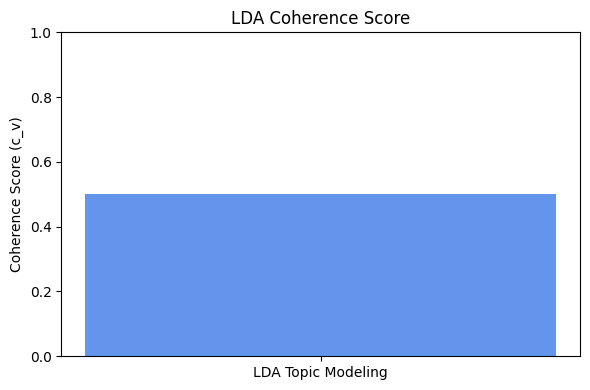

SOM Silhouette Score: 0.6311


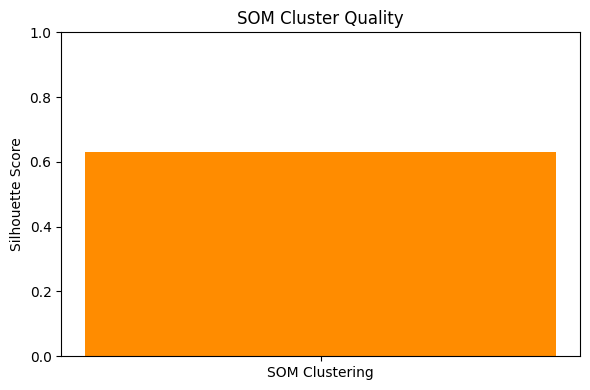

In [12]:
lda_score = visualize_lda_coherence(lda_model, tokenized_posts, dictionary)
som_score = visualize_som_silhouette(senti_vectors, clusters)
